In [1]:
# hide
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None)

df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]

# df = df.sample(frac=0.1, random_state=1)
train_cols = df.columns[0:-1]
label = df.columns[-1]
X = df[train_cols]
y = df[label].apply(lambda x: 0 if x == " <=50K" else 1) #Turning response into 0 and 1

seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

class ColumnSelector(BaseEstimator, TransformerMixin):
    def fit(self, column):
        self.column = column
        
    def transform(self, X):
        return X[self.column].values
    
    def inverse_transform(self, X):
        return X
    
class Reshaper(BaseEstimator, TransformerMixin):
    def transform(self, X):
        return X.reshape(-1,1)
    
    def inverse_transform(self, X):
        return X.reshape(-1)

In [6]:
class Featurizer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns):
        self.categorical_columns = categorical_columns
        
    def fit(self, df):
        pipelines = []
        for col in df.columns.values:
            steps = []
            column_selector = ColumnSelector()
            column_selector.fit(col)
            
            column_values = column_selector.transform(df)
            
            steps.append((col,column_selector))
            
            if col in self.categorical_columns:
                le = LabelEncoder()
                le.fit(column_values)
                column_values = le.transform(column_values)
                
                steps.append(("label_encoding",le))
                
            reshaper = Reshaper()
            column_values = reshaper.transform(column_values)
            steps.append(("reshape", reshaper))
            
            min_max = MinMaxScaler()
            min_max.fit(column_values)
            steps.append(("min_max", min_max))
            
            pipeline = Pipeline(steps)
            pipelines.append((col, pipeline))

        self.pipelines = FeatureUnion(pipelines)
        return self
    
    def transform(self, df):
        return self.pipelines.transform(df)

In [7]:
categorical_columns = ["WorkClass","Education","MaritalStatus", "Occupation", "Relationship", 
                       "Race", "Gender", "NativeCountry"]

featurizer = Featurizer(categorical_columns)

In [8]:
X_train_normalized = featurizer.fit_transform(X_train)

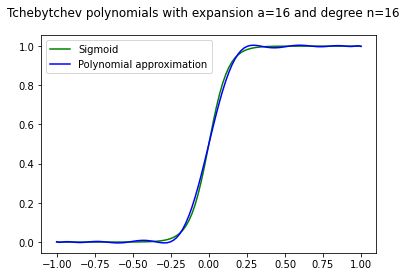

In [9]:
from sklearn.tree import DecisionTreeClassifier
from cryptotree.tree import NeuralRandomForest, SigmoidTreeMaker, TanhTreeMaker
from cryptotree.polynomials import plot_graph_function_approximation

max_depth = 3

dilatation_factor = 16
polynomial_degree = dilatation_factor

plot_graph_function_approximation(torch.sigmoid,
                                  dilatation_factor=dilatation_factor,polynomial_degree=polynomial_degree)

sigmoid_tree_maker = SigmoidTreeMaker(use_polynomial=True,
                                  dilatation_factor=dilatation_factor, polynomial_degree=polynomial_degree)

tanh_tree_maker = TanhTreeMaker(use_polynomial=True,
                                  dilatation_factor=dilatation_factor, polynomial_degree=polynomial_degree)

In [10]:
tree = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
tree.fit(X_train_normalized, y_train)

pred = tree.predict(X_train_normalized)

neural_tree = tanh_tree_maker.make_tree(tree)

with torch.no_grad():
    neural_pred = neural_tree(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()

(neural_pred == pred).mean()

0.8657478501228502

In [18]:
rf = RandomForestClassifier(max_depth=max_depth, random_state=0)
rf.fit(X_train_normalized, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [11]:


pred = rf.predict(X_train_normalized)

neural_rf = NeuralRandomForest(rf.estimators_, tanh_tree_maker)

with torch.no_grad():
    neural_pred = neural_rf(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()

print(f"Original accuracy : {(pred == y_train).mean()}")
print(f"Accuracy : {(neural_pred == y_train).mean()}")
print(f"Same output : {(neural_pred == pred).mean()}")

Original accuracy : 0.8257831695331695
Accuracy : 0.7574477886977887
Same output : 0.9136977886977887


In [65]:
neural_rf = NeuralRandomForest(rf.estimators_, sigmoid_tree_maker)

rf = RandomForestClassifier(max_depth=max_depth, random_state=0)
rf.fit(X_train_normalized, y_train)

pred = rf.predict(X_train_normalized)

with torch.no_grad():
    neural_pred = neural_rf(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()

print(f"Original accuracy : {(pred == y_train).mean()}")
print(f"Accuracy : {(neural_pred == y_train).mean()}")
print(f"Same output : {(neural_pred == pred).mean()}")

Original accuracy : 0.8257831695331695
Accuracy : 0.29549293611793614
Same output : 0.14139281326781328


In [11]:
from torch.utils import data
import numpy as np

class TabularDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X: np.ndarray, y: np.ndarray):
        'Initialization'
        self.X, self.y = X,y

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Load data and get label
        X = torch.tensor(self.X[index]).float()
        y = torch.tensor(self.y[index])

        return X, y

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)
X_train_normalized, X_valid_normalized, y_train, y_valid = train_test_split(featurizer.transform(X_train), 
                                                                            y_train,
                                                                            train_size=0.8)

In [13]:
train_ds = TabularDataset(X_train_normalized, y_train.values)
valid_ds = TabularDataset(X_valid_normalized, y_valid.values)

In [14]:
bs = 128

train_dl = data.DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = data.DataLoader(valid_ds, batch_size=bs)
fix_dl = data.DataLoader(train_ds, batch_size=bs, shuffle=False)

In [41]:
from fastai.basic_data import DataBunch
import torch.nn as nn
from fastai.tabular.learner import Learner
from fastai.metrics import accuracy

In [42]:
from cryptotree.tree import CrossEntropyLabelSmoothing

In [43]:
tree_maker = sigmoid_tree_maker

model = NeuralRandomForest(rf.estimators_, tree_maker=tree_maker)

In [44]:
model.freeze_layer("comparator")
model.freeze_layer("matcher")

In [45]:
for p in model.parameters():
    print(p.shape, p.requires_grad)

torch.Size([14, 7, 100]) False
torch.Size([7, 100]) False
torch.Size([8, 7, 100]) False
torch.Size([8, 100]) False
torch.Size([2, 8, 100]) True
torch.Size([2, 100]) True


In [46]:
pred = rf.predict(X_train_normalized)

with torch.no_grad():
    neural_pred = model(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()

print(f"Original accuracy : {(pred == y_train).mean()}")
print(f"Accuracy : {(neural_pred == y_train).mean()}")
print(f"Same output : {(neural_pred == pred).mean()}")

Original accuracy : 0.8281504942892792
Accuracy : 0.3023802668202323
Same output : 0.1545253863134658


In [47]:
data = DataBunch(train_dl, valid_dl,fix_dl=fix_dl)

criterion = CrossEntropyLabelSmoothing()

learn = Learner(data, model, loss_func=criterion, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


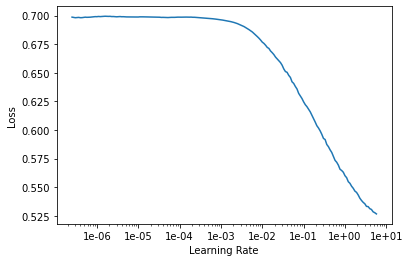

In [39]:
learn.lr_find(num_it=200)
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(2,1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.456688,0.437200,0.833205,00:03
1,0.429196,0.429110,0.838196,00:02


In [49]:
pred = rf.predict(X_train_normalized)

with torch.no_grad():
    neural_pred = model(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()

print(f"Original accuracy : {(pred == y_train).mean()}")
print(f"Accuracy : {(neural_pred == y_train).mean()}")
print(f"Same output : {(neural_pred == pred).mean()}")

Original accuracy : 0.8281504942892792
Accuracy : 0.8412035704002303
Same output : 0.9242729628563202


In [51]:
model.head[:,:,0]

tensor([[ 1.7077,  1.6375,  0.8391, -2.3346, -0.0979, -0.9763, -9.7448, -5.4619],
        [-2.3599, -2.4039, -1.9025,  1.4050, -1.0201, -0.1388,  8.6256,  4.3901]],
       grad_fn=<SelectBackward>)

In [54]:
i = 0

x = X_train_normalized[i]

pred = rf.predict_proba(x.reshape(1,-1))
neural_pred = model(torch.tensor(x).float().unsqueeze(0))

In [60]:
neural_pred

tensor([[ 1.1485, -1.2419]], grad_fn=<AddBackward0>)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f820ccf6160>)

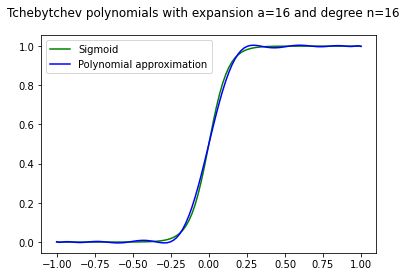

In [61]:
from cryptotree.polynomials import (chebyshev_approximation, polynomial_approximation_coefficients, 
plot_graph_function_approximation)
import torch

dilatation_factor = 16
degree = dilatation_factor

p,_ = chebyshev_approximation(torch.sigmoid, dilatation_factor=dilatation_factor,
                                              polynomial_degree=degree)
coeffs = polynomial_approximation_coefficients(torch.sigmoid, dilatation_factor=dilatation_factor,
                                              polynomial_degree=degree)
plot_graph_function_approximation(torch.sigmoid, dilatation_factor=dilatation_factor,
                                              polynomial_degree=degree)

In [64]:
import numpy as np 

PRECISION_BITS = 30
UPPER_BITS = 9

polynomial_multiplications = int(np.ceil(np.log2(degree))) + 1
n_polynomials = 2
matrix_multiplications = 2

depth = matrix_multiplications + polynomial_multiplications * n_polynomials

poly_modulus_degree = 16384

moduli = [PRECISION_BITS + UPPER_BITS] + (depth) * [PRECISION_BITS] + [PRECISION_BITS + UPPER_BITS]
print(moduli)
print(sum(moduli))

[39, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 39]
438


In [76]:
model(torch.tensor(x).float().unsqueeze(0))

tensor([[ 1.1485, -1.2419]], grad_fn=<AddBackward0>)

In [75]:
from cryptotree.cryptotree import HomomorphicNeuralRandomForest, HomomorphicTreeEvaluator, HomomorphicTreeFeaturizer
from cryptotree.polynomials import polyeval_tree
from seal import *

h_rf = HomomorphicNeuralRandomForest(model)

tree_evaluator = HomomorphicTreeEvaluator.from_model(h_rf, tree_maker.coeffs, 
                                                   polyeval_tree, evaluator, encoder, relin_keys, galois_keys, 
                                                   scale)

featurizer = HomomorphicTreeFeaturizer(h_rf.return_comparator(), encoder, encryptor, scale)

x = X_train_normalized[0]
ctx = featurizer.encrypt(x)

outputs = tree_evaluator(ctx)

for output in outputs:
    ptx = Plaintext()
    decryptor.decrypt(output, ptx)
    
    values = DoubleVector()
    encoder.decode(ptx, values)
    
    output = sum(list(values))
    print(output)

1.1463241577148444
-1.2490234375000053


In [65]:
from cryptotree.seal_helper import create_seal_globals, append_globals_to_builtins
import builtins

create_seal_globals(globals(), poly_modulus_degree, moduli, PRECISION_BITS)
append_globals_to_builtins(globals(), builtins)

In [59]:
torch.softmax(neural_pred, dim=1)

tensor([[0.9161, 0.0839]], grad_fn=<SoftmaxBackward>)

In [ ]:
with torch.no_grad():
    valid_pred = model(torch.tensor(X_valid_normalized).float()).argmax(dim=1).numpy()

In [129]:
tree = DecisionTreeClassifier(max_depth=3, random_state=0)
tree.fit(X_train_normalized, y_train)

n_nodes = tree.tree_.node_count
children_left = tree.tree_.children_left
children_right = tree.tree_.children_right
feature = tree.tree_.feature
threshold = tree.tree_.threshold

# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True
        
print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

pred = tree.predict(X_train_normalized)

dilatation_factor = 32
polynomial_degree = dilatation_factor

sigmoid_tree_maker = SigmoidTreeMaker(use_polynomial=True,
                                  dilatation_factor=dilatation_factor, polynomial_degree=polynomial_degree)

neural_tree = sigmoid_tree_maker.make_tree(tree)

with torch.no_grad():
    neural_pred = neural_tree(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()

(neural_pred == pred).mean()

The binary tree structure has 15 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 0] <= 0.17123287916183472 else to node 8.
	node=1 test node: go to node 2 if X[:, 0] <= 0.1164383552968502 else to node 5.
		node=2 test node: go to node 3 if X[:, 0] <= 0.0890410952270031 else to node 4.
			node=3 leaf node.
			node=4 leaf node.
		node=5 test node: go to node 6 if X[:, 1] <= 0.7000000178813934 else to node 7.
			node=6 leaf node.
			node=7 leaf node.
	node=8 test node: go to node 9 if X[:, 1] <= 0.4333333373069763 else to node 12.
		node=9 test node: go to node 10 if X[:, 0] <= 0.25342465192079544 else to node 11.
			node=10 leaf node.
			node=11 leaf node.
		node=12 test node: go to node 13 if X[:, 1] <= 0.7000000178813934 else to node 14.
			node=13 leaf node.
			node=14 leaf node.



0.8073172604422605

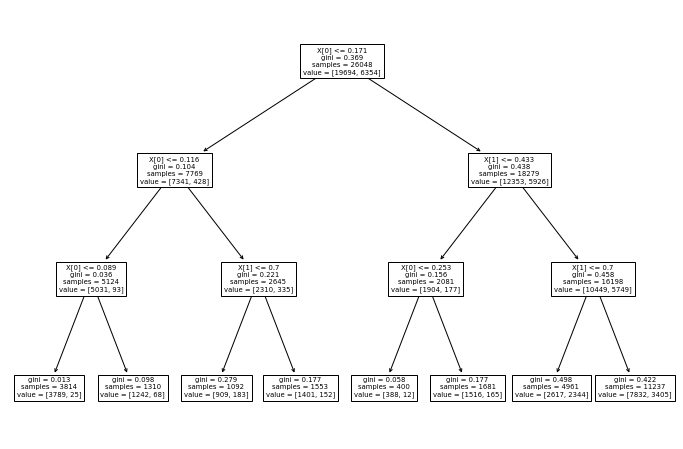

In [85]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12,8))
artists = plot_tree(tree, ax=ax)

In [120]:
i = 0
x = X_train_normalized[i]

In [121]:
x

array([0.30136986, 0.06666667])

In [122]:
pred = tree.predict_proba(x.reshape(1,-1))
pred

array([[0.90184414, 0.09815586]])

In [123]:
x = torch.tensor(x).float()

In [124]:
neural_tree.comparator.weight, neural_tree.comparator.bias

(Parameter containing:
 tensor([[1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [0., 1.]], requires_grad=True),
 Parameter containing:
 tensor([-0.1712, -0.1164, -0.0890, -0.7000, -0.4333, -0.2534, -0.7000],
        requires_grad=True))

In [125]:
comparisons = neural_tree.comparator(x)
comparisons = neural_tree.activation(comparisons)

In [126]:
comparisons

tensor([ 0.8635,  0.9512,  0.9778, -0.0032,  0.0038,  0.6511, -0.0032],
       grad_fn=<AddBackward0>)

In [108]:
neural_tree.matcher.weight, neural_tree.matcher.bias

(Parameter containing:
 tensor([[-0.1429, -0.1429, -0.1429,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.1429, -0.1429,  0.1429,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.1429,  0.1429,  0.0000, -0.1429,  0.0000,  0.0000,  0.0000],
         [-0.1429,  0.1429,  0.0000,  0.1429,  0.0000,  0.0000,  0.0000],
         [ 0.1429,  0.0000,  0.0000,  0.0000, -0.1429, -0.1429,  0.0000],
         [ 0.1429,  0.0000,  0.0000,  0.0000, -0.1429,  0.1429,  0.0000],
         [ 0.1429,  0.0000,  0.0000,  0.0000,  0.1429,  0.0000, -0.1429],
         [ 0.1429,  0.0000,  0.0000,  0.0000,  0.1429,  0.0000,  0.1429]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0714, -0.0714, -0.0714, -0.2143, -0.0714, -0.2143, -0.2143, -0.3571],
        requires_grad=True))

In [109]:
matches = neural_tree.matcher(comparisons)
matches = neural_tree.activation(matches)
matches

tensor([-9.7765e-04,  2.6185e-03, -6.1539e-03,  2.6173e-03, -2.3516e-03,
         1.0006e+00, -6.9255e-03,  2.6083e-03], grad_fn=<AddBackward0>)

In [110]:
neural_tree.head.weight, neural_tree.head.bias

(Parameter containing:
 tensor([[-0.8076, -0.9369, -0.9538, -0.9289, -0.9803, -0.9230, -0.8671, -0.6023],
         [-0.3214, -0.3192, -0.3133, -0.3149, -0.3220, -0.3143, -0.2036, -0.1497]],
        requires_grad=True),
 Parameter containing:
 tensor([1.0000, 0.3226], requires_grad=True))

In [111]:
output = neural_tree.head(matches)
output

tensor([0.0849, 0.0105], grad_fn=<AddBackward0>)

In [112]:
(pred == y_train).mean()

<ipython-input-112-f6ede1145482>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  (pred == y_train).mean()


ValueError: Lengths must match to compare

In [21]:
categorical_columns = ["WorkClass","Education","MaritalStatus", "Occupation", "Relationship", 
                       "Race", "Gender", "NativeCountry"]

featurizer = Featurizer(categorical_columns)

In [22]:
X_train_normalized = featurizer.fit_transform(X_train)

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
rf = RandomForestClassifier(max_depth=5,random_state=0)

In [39]:
rf.fit(X_train_normalized, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [60]:
pred_train = rf.predict(X_train_normalized)

(pred_train == y_train).mean()

0.8490479115479116

In [41]:
from cryptotree.tree import SigmoidTreeMaker, NeuralRandomForest

In [79]:
tree_maker = SigmoidTreeMaker(dilatation_factor=32)

neural_rf = NeuralRandomForest(rf.estimators_, tree_maker)

In [43]:
import torch

In [44]:
neural_pred_train = neural_rf(torch.tensor(X_train_normalized).float())

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/danywin/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-070861204721>", line 1, in <module>
    neural_pred_train = neural_rf(torch.tensor(X_train_normalized).float())
  File "/home/danywin/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 550, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/danywin/cryptotree/cryptotree/tree.py", line 269, in forward
    comparisons = self.activation(comparisons)
  File "/home/danywin/.local/lib/python3.8/site-packages/numpy/polynomial/_polybase.py", line 388, in __call__
    return self._val(arg, self.coef)
  File "/home/danywin/.local/lib/python3.8/site-packages/numpy/polynomial/chebyshev.py", line 1156, in chebval
    return c0 + c1*x
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most 

KeyboardInterrupt: 

In [67]:
from sklearn.tree import DecisionTreeClassifier

In [49]:
from torch.utils import data
import numpy as np

class TabularDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X: np.ndarray, y: np.ndarray):
        'Initialization'
        self.X, self.y = X,y

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Load data and get label
        X = torch.tensor(self.X[index]).float()
        y = torch.tensor(self.y[index])

        return X, y

In [70]:
tree = DecisionTreeClassifier(max_depth=5, random_state=0)
tree.fit(X_train_normalized, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [71]:
pred_train = tree.predict(X_train_normalized)

(pred_train == y_train).mean()

0.8523111179361179

In [80]:
neural_tree = tree_maker.make_tree(tree)

In [81]:
x = X_train_normalized[0]

In [82]:
tree.predict_proba(x.reshape(1,-1))

array([[0.9058927, 0.0941073]])

In [83]:
neural_tree(torch.tensor(x).unsqueeze(0).float())

tensor([[-2.8494, -0.9400]], grad_fn=<AddmmBackward>)

In [50]:
train_ds = TabularDataset(X_train_normalized, y)

In [52]:
train_dl = data.DataLoader(train_ds, batch_size=32)

In [53]:
import tqdm

In [61]:
x = X_train_normalized[0]

In [65]:
rf.predict_proba(x.reshape(1,-1))

array([[0.78290576, 0.21709424]])

In [66]:
neural_rf(torch.tensor(x).float().unsqueeze(0))

tensor([[-7.3053, -2.3616]], grad_fn=<AddBackward0>)

In [54]:
loader = tqdm.tqdm(train_dl)

output = []

for X,y in loader:
    pred = neural_rf(X)
    output.append(pred.argmax(dim=1) == y)

100%|██████████| 814/814 [00:18<00:00, 43.68it/s]


In [59]:
torch.stack(output).float().mean()

tensor(0.2396)

In [32]:
pred_test = rf.predict(featurizer.transform(X_test))

(pred_test == y_test).mean()

ValueError: y contains previously unseen labels: ' Holand-Netherlands'

In [115]:
featurizer.pipelines.transform(X_train[["Education","Age"]])

array([[0.06666667, 0.30136986],
       [0.6       , 0.50684932],
       [0.73333333, 0.20547945],
       ...,
       [0.6       , 0.1369863 ],
       [0.73333333, 0.57534247],
       [0.6       , 0.21917808]])

In [116]:
pipe = featurizer.pipelines.transformer_list[0][1]

In [117]:
x = pipe.transform(X_train)

In [118]:
pipe.inverse_transform(x)

IndexError: arrays used as indices must be of integer (or boolean) type

In [77]:
s = pipe[2].transform(r)

ValueError: Expected 2D array, got 1D array instead:
array=[ 1.  9. 11. ...  9. 11.  9.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [16]:
ebm.attribute_sets_

[{'n_attributes': 1, 'attributes': [0]},
 {'n_attributes': 1, 'attributes': [1]},
 {'n_attributes': 1, 'attributes': [2]},
 {'n_attributes': 1, 'attributes': [3]},
 {'n_attributes': 1, 'attributes': [4]},
 {'n_attributes': 1, 'attributes': [5]},
 {'n_attributes': 1, 'attributes': [6]},
 {'n_attributes': 1, 'attributes': [7]},
 {'n_attributes': 1, 'attributes': [8]},
 {'n_attributes': 1, 'attributes': [9]},
 {'n_attributes': 1, 'attributes': [10]},
 {'n_attributes': 1, 'attributes': [11]},
 {'n_attributes': 1, 'attributes': [12]},
 {'n_attributes': 1, 'attributes': [13]}]